In [6]:
import os
import pyvista as pv
import numpy as np
import nibabel as nib
import pydicom
from pydicom import dcmread
from skimage import measure
import open3d as o3d

Skipping unsupported file: .DS_Store
Loaded mesh from /Users/lucas/Desktop/Brainhack School/EEG_electrode_localization_project/data/raw_data/Test_obj1/model_mesh3.obj with 1325124 points and 441708 faces.


/Users/lucas/miniconda3/envs/brainhack/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


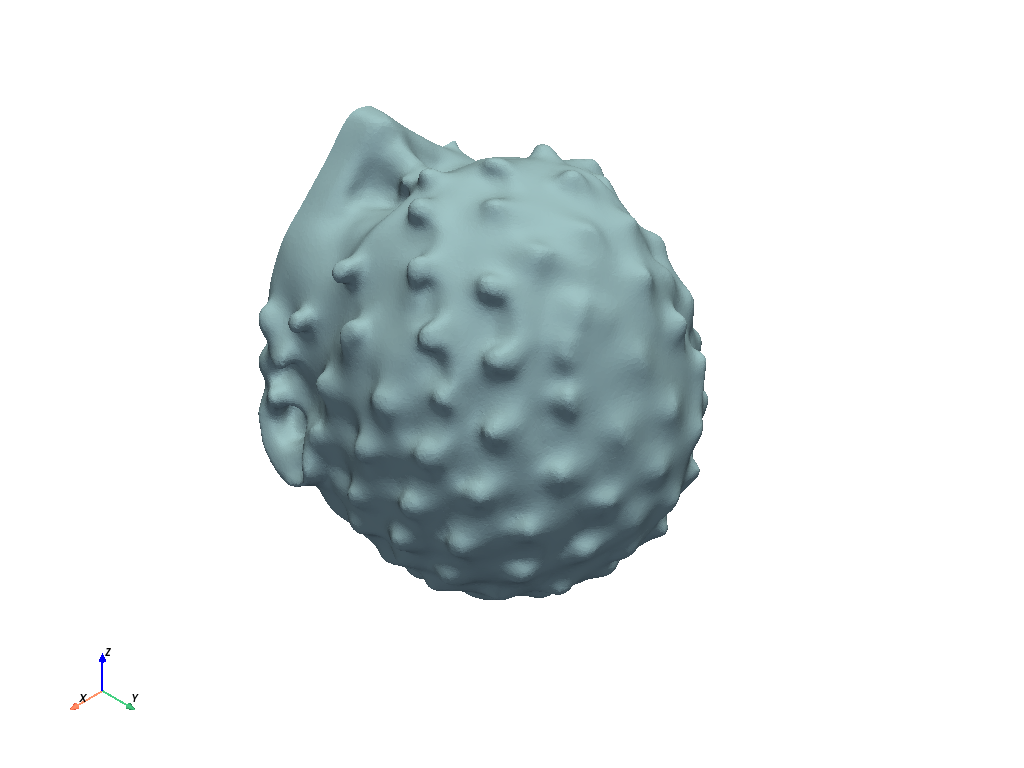

Saved cleaned mesh to /Users/lucas/Desktop/Brainhack School/EEG_electrode_localization_project/data/processed_data/model_mesh3.obj



In [7]:
def remove_bust(mesh: pv.PolyData, visualize=False):
    """
    Removes the lower (torso) portion of a mesh based on a Y-axis threshold.
    This helps isolate the head for neuroimaging applications.

    Parameters:
        mesh (pv.PolyData): The input mesh to clean.
        visualize (bool): If True, displays the cleaned mesh.

    Returns:
        pv.PolyData: The cleaned mesh with bust removed (if applicable).
    """
    bounds = mesh.bounds
    y_min, y_max = bounds[2], bounds[3]  # y-axis limits
    head_cut_y = y_min + 0.6 * (y_max - y_min)  # threshold to separate head vs bust

    try:
        # Clip away everything below the cut line (invert=False keeps top part)
        clipped = mesh.clip(normal='y', origin=(0, head_cut_y, 0), invert=False)

        # Ensure we have a clean, triangulated surface mesh after clipping
        cleaned = clipped.extract_surface().triangulate().clean()
    except Exception as e:
        print("Error during bust removal:", e)
        return mesh  # Return original mesh as fallback

    # If clipping resulted in an empty mesh, fallback
    if cleaned.n_points == 0 or cleaned.n_faces == 0:
        print("Warning: bust removal resulted in empty mesh, skipping.")
        return mesh

    if visualize:
        cleaned.plot()

    return cleaned

def process_surface_mesh(input_path, output_path, visualize=False):
    """
    Processes a single surface mesh file:
    - Loads it with PyVista
    - Cleans and optionally clips the bust
    - Saves it as an OBJ file

    Parameters:
        input_path (str): Path to input 3D file
        output_path (str): Path to save the cleaned OBJ file
        visualize (bool): If True, show the mesh at each step
    """
    try:
        # Load mesh
        mesh = pv.read(input_path)
        print(f"Loaded mesh from {input_path} with {mesh.n_points} points and {mesh.n_faces} faces.")

        # Clean up redundant/duplicate elements
        mesh = mesh.clean()

        # Remove the bust
        mesh = remove_bust(mesh, visualize=visualize)

        # Save cleaned mesh as OBJ
        mesh.save(output_path)
        print(f"Saved cleaned mesh to {output_path}\n")

        return mesh

    except Exception as e:
        print(f" Error processing {input_path}: {e}\n")

def load_nifti_volume(file_path):
    """
    Loads a NIfTI file and returns the image data and affine.

    Parameters:
        file_path (str): Path to the NIfTI file.

    Returns:
        tuple: A tuple containing the image data as a NumPy array and the affine matrix.
    """
    img = nib.load(file_path)
    data = img.get_fdata()
    affine = img.affine
    return data, affine

def load_dicom_volume(dicom_dir):
    """
    Loads a DICOM series and returns the image data and affine.

    Parameters:
        dicom_dir (str): Path to the directory containing DICOM files.

    Returns:
        tuple: A tuple containing the image data as a NumPy array and the affine matrix.
    """
    # Read all DICOM files in the directory
    files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    files.sort()  # Ensure files are in the correct order

    # Read the first file to get metadata
    ds = pydicom.dcmread(files[0])
    pixel_spacing = ds.PixelSpacing
    slice_thickness = ds.SliceThickness
    image_orientation = ds.ImageOrientationPatient
    image_position = ds.ImagePositionPatient

    # Read image data from all slices
    slices = [pydicom.dcmread(f) for f in files]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))  # Sort by Z position
    data = np.stack([s.pixel_array for s in slices], axis=-1)

    # Construct affine matrix
    affine = np.eye(4)
    affine[0, 0] = float(pixel_spacing[0])
    affine[1, 1] = float(pixel_spacing[1])
    affine[2, 2] = float(slice_thickness)
    affine[0:3, 3] = image_position

    return data, affine

def volume_to_mesh(data, affine, threshold=300):
    """
    Converts volumetric data to a mesh using the marching cubes algorithm.

    Parameters:
        data (np.ndarray): The volumetric data.
        affine (np.ndarray): The affine transformation matrix.
        threshold (float): The threshold value for marching cubes.

    Returns:
        pv.PolyData: The generated mesh.
    """
    # Apply marching cubes
    verts, faces, normals, _ = measure.marching_cubes(data, level=threshold)

    # Apply affine transformation to vertices
    verts_homogeneous = np.c_[verts, np.ones(len(verts))]
    transformed_verts = verts_homogeneous @ affine.T
    transformed_verts = transformed_verts[:, :3]

    # Create mesh
    mesh = pv.PolyData(transformed_verts, faces)
    return mesh

def process_volume_file(input_path, output_path, visualize=False):
    """
    Processes a volumetric file (.nii, .nii.gz, .dcm):
    - Loads the volume
    - Converts it to a mesh
    - Removes the bust
    - Saves it as an OBJ file

    Parameters:
        input_path (str): Path to the input file or directory.
        output_path (str): Path to save the OBJ file.
        visualize (bool): If True, visualize the mesh.
    """
    try:
        if input_path.endswith(('.nii', '.nii.gz')):
            data, affine = load_nifti_volume(input_path)
        elif os.path.isdir(input_path):
            data, affine = load_dicom_volume(input_path)
        else:
            print(f"Unsupported volumetric file: {input_path}")
            return

        # Convert volume to mesh
        mesh = volume_to_mesh(data, affine)

        # Remove the bust
        mesh = remove_bust(mesh, visualize=visualize)

        # Save mesh as OBJ
        mesh.save(output_path)
        print(f"Saved mesh to {output_path}\n")

    except Exception as e:
        print(f" Error processing {input_path}: {e}\n")

def process_all_files(input_folder, output_folder, visualize=False):
    """
    Processes all supported 3D files in a directory.

    Parameters:
        input_folder (str): Path to the folder containing 3D files.
        output_folder (str): Destination to save processed OBJ files.
        visualize (bool): If True, visualizes each processed mesh.
    """
    supported_surface_exts = ['.obj', '.ply', '.stl', '.off']
    supported_volume_exts = ['.nii', '.nii.gz']

    os.makedirs(output_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        input_path = os.path.join(input_folder, file_name)
        name, ext = os.path.splitext(file_name)
        ext = ext.lower()

        output_file_name = name + ".obj"
        output_path = os.path.join(output_folder, output_file_name)

        if ext in supported_surface_exts:
            mesh = process_surface_mesh(input_path, output_path, visualize=visualize)
        elif ext in supported_volume_exts:
            process_volume_file(input_path, output_path, visualize=visualize)
        elif os.path.isdir(input_path):
            # Assume directory contains DICOM files
            process_volume_file(input_path, output_path, visualize=visualize)
        else:
            print(f"Skipping unsupported file: {file_name}")

    return mesh


input_directory = "/Users/lucas/Desktop/Brainhack School/EEG_electrode_localization_project/data/raw_data/Test_obj1"
output_directory = "/Users/lucas/Desktop/Brainhack School/EEG_electrode_localization_project/data/processed_data/"
mesh = process_all_files(input_directory, output_directory, visualize=True)


/Users/lucas/miniconda3/envs/brainhack/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


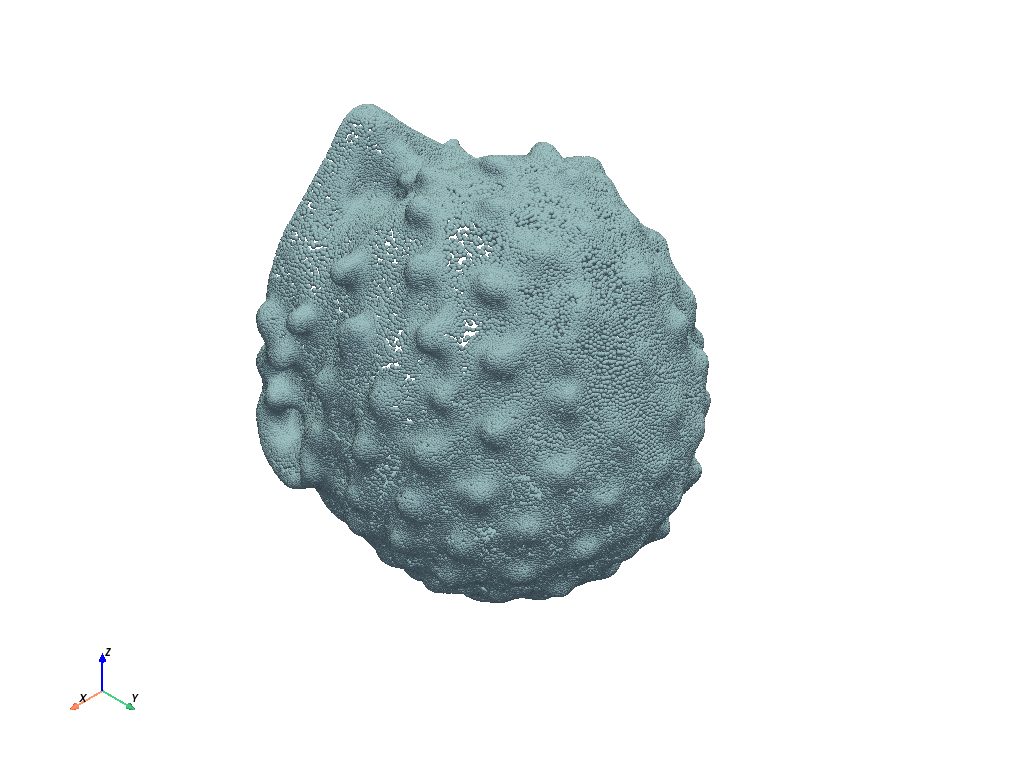

In [8]:
point_cloud = pv.PolyData(mesh.points)
point_cloud.plot(render_points_as_spheres=True)

In [ ]:
# This is version does not account for the difference in points between the PointCloud
# # Assume you already have this from your code
# point_cloud = pv.PolyData(mesh.points)

# # Convert PyVista points (numpy array) to Open3D point cloud
# o3d_pc = o3d.geometry.PointCloud()
# o3d_pc.points = o3d.utility.Vector3dVector(np.asarray(point_cloud.points))

# # Optional: If you have color data in PyVista
# # o3d_pc.colors = o3d.utility.Vector3dVector(np.asarray(point_cloud.point_data['Colors']) / 255.0)

# # Define where to save
# output_dir = "/Users/lucas/Desktop/Brainhack School/EEG_electrode_localization_project/data/processed_data/"
# os.makedirs(output_dir, exist_ok=True)
# output_path = os.path.join(output_dir, "pointcloud_example.ply")  # Can also use .pcd or .xyz

# # Save as a .ply file
# o3d.io.write_point_cloud(output_path, o3d_pc)

# print(f"Point cloud saved to: {output_path}")
#----------------------------------------------------------------------------------

# This Version should account for standardizing the PointCloud to 200000 points.
# This is important for feeding standardized data to PointNet++

# Load your mesh (ensure this has been done before)
# For example:
# mesh = pv.read("your_file.obj")

# Create a PyVista point cloud from mesh vertices
point_cloud = pv.PolyData(mesh.points)

# Resample to 200,000 points
n_points = 200000
points = point_cloud.points

if len(points) > n_points:
    sampled_points = points[np.random.choice(len(points), n_points, replace=False)]
else:
    sampled_points = points[np.random.choice(len(points), n_points, replace=True)]

# Convert to Open3D point cloud
o3d_pc = o3d.geometry.PointCloud()
o3d_pc.points = o3d.utility.Vector3dVector(sampled_points)

# Optional: Add color if available
# if 'Colors' in point_cloud.point_data:
#     colors = np.asarray(point_cloud.point_data['Colors'])[indices] / 255.0
#     o3d_pc.colors = o3d.utility.Vector3dVector(colors)

# Save point cloud to .ply
output_dir = "/Users/lucas/Desktop/Brainhack School/EEG_electrode_localization_project/data/processed_data/"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "pointcloud_200k.ply")
o3d.io.write_point_cloud(output_path, o3d_pc)

print(f"Point cloud saved to: {output_path}")


Point cloud saved to: /Users/lucas/Desktop/Brainhack School/EEG_electrode_localization_project/data/processed_data/pointcloud_example.ply
